## Computer Vision

1. Face Recognition:
Use CV to recognize faces for user's logins validation.

2. Image Similarity Search:
Use CV to search images with other image as query and find similar images.

## Face Recognition

In [20]:
from facenet_pytorch import InceptionResnetV1
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mtcnn import MTCNN
from utils.computer_vision import FaceDataset, plot_images_horizontal
from torch.utils.data import DataLoader
from qdrant_client import QdrantClient
from qdrant_client.http import models

GPU agnostic

In [41]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device 

'cpu'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


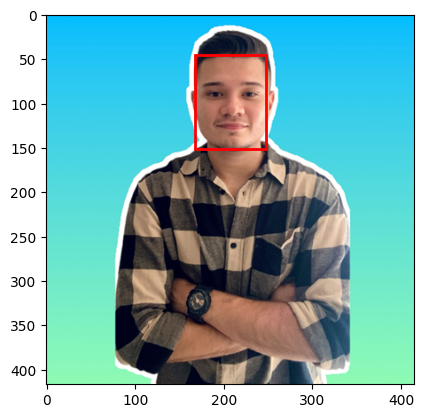

In [28]:
# Load and image
img = PIL.Image.open("../assets/examples/me.png").convert(mode="RGB")

# Convert it to array
img = np.array(img)

# Create mtcc object
detector = MTCNN(min_face_size=30)

# Detect faces
resultados = detector.detect_faces(img)

# Plots
fig, ax = plt.subplots()
ax.imshow(img)
for resultado in resultados:
    x, y, w, h = resultado['box']
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


Let's use MTCNN tools from facenet_pytorch and crop the face 

In [4]:
del MTCNN
from facenet_pytorch import MTCNN

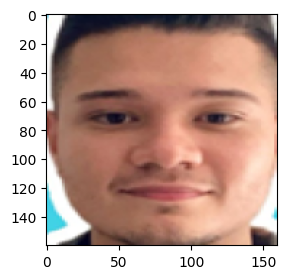

In [5]:
mtcnn = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=False)
cropped_img = mtcnn(img).permute(1, 2, 0).int().numpy()
plt.figure(figsize=(3,3))
plt.imshow(cropped_img)
plt.show()

Let's compute a Embedding

In [6]:
mtcnn_detector = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=True)
resnet = InceptionResnetV1(pretrained="vggface2", classify=False, device = device).eval()
cropped_img = mtcnn_detector(img).unsqueeze(0)
embedding = resnet(cropped_img)
print(f"Our embedding has a dimension of {embedding.shape[1]}")

Our embedding has a dimension of 512


Let's create our FaceDataset

In [12]:
ds = FaceDataset(root_dir="../data/unstructured/imgs")
dataloader = DataLoader(ds, batch_size=4, shuffle=True)

Plot some images

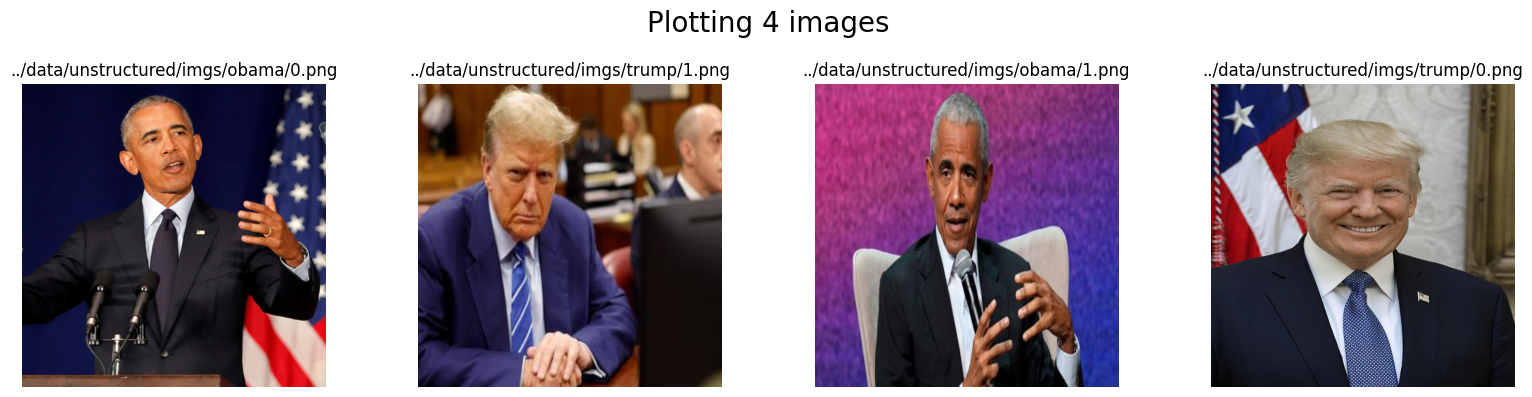

In [8]:
test_imgs, labels_imgs = next(iter(dataloader))
test_imgs = [np.array(img) for img in test_imgs]
plot_images_horizontal(test_imgs, labels_imgs)

Process the dataset by batch detecting faces and computing embeddings 

In [13]:
embeddings = []
used = []
with torch.no_grad():
    for run, (batch, idxs) in enumerate(dataloader):
        print (f"Batch # {run+1} of size {dataloader.batch_size}")
        to_use = []
        batch_images = []
        not_used = []
        for idx, img in enumerate (batch):
            detected_face, prob = mtcnn_detector(img, return_prob=True)
            if prob is not None:
                batch_images.append(detected_face.to(device))
                used.append(idxs[idx])
            else:
                not_used.append(idxs[idx])

        if len (batch_images) > 0:
            embedding = resnet(torch.stack(batch_images)).to("cpu")
            used.extend(to_use)
            embeddings.append(embedding)

            del batch_images, to_use, detected_face, embedding
            torch.cuda.empty_cache()

Batch # 1 of size 4s
Batch # 2 of size 4s


Persists embeddings and labels

In [20]:
data = [torch.cat(embeddings, dim=0), used]
torch.save(data, "../data/unstructured/imgs_embeddings/data.pt")

Create client

In [2]:
client = QdrantClient(host="localhost", port=6333)

Recreate collection

In [43]:
my_collection = "face_embeddings2"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

True

Upsert records

In [66]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=[i for i in range(len(used))],
        vectors=torch.cat(embeddings, dim=0).tolist(),
        payloads = [{"path": path[1:]} for path in used]
    )
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

Test with an image

In [49]:
import PIL.Image

test = PIL.Image.open("../assets/examples/obama_test.png")
test = test.convert(mode="RGB")

Compute embeddings

In [67]:
detected_face, prob = mtcnn_detector(test, return_prob=True)
embedding = resnet(detected_face.unsqueeze(0))

Search into collection

In [68]:
client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold=0.6,
    limit=10
)

[ScoredPoint(id=4, version=1, score=0.69455683, payload={'path': './data/unstructured/imgs/obama/2.png'}, vector=None, shard_key=None),
 ScoredPoint(id=3, version=1, score=0.6854315, payload={'path': './data/unstructured/imgs/obama/0.png'}, vector=None, shard_key=None),
 ScoredPoint(id=1, version=1, score=0.632252, payload={'path': './data/unstructured/imgs/obama/1.png'}, vector=None, shard_key=None)]

## Product's Images Similarity Search

Load model for Feature Extraction and Image Processor

In [1]:
from transformers import ViTImageProcessor, ViTModel

model_id = 'jolual2747/vit-clothes-classification'
processor = ViTImageProcessor.from_pretrained(model_id)
model = ViTModel.from_pretrained(model_id, force_download = True)

/home/josealcocer27/.cache/pypoetry/virtualenvs/pycon-colombia-2024-rDJfgf35-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-29 01:16:47.559996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 01:16:49.328000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of ViTModel were not initialized from the model checkpoint at jolual2747/vit-clothes-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

In [10]:
model.save_pretrained("../assets/embedding_model")

In [ ]:
model = model.to(device)

Load Dataset and download images from URLs

In [2]:
from datasets import load_dataset
from utils.computer_vision import fetch_images

num_threads = 20
dset = load_dataset('DBQ/Matches.Fashion.Product.prices.France', download_mode="force_redownload")
dset = dset.shuffle(42)["train"].select(range(100))
dset = dset.map(fetch_images, batched=True, batch_size=20, fn_kwargs={"num_threads": num_threads})

Map: 100%|██████████| 100/100 [00:04<00:00, 21.47 examples/s]


Preprocess images

In [19]:
def preprocess_image(batch: dict):
    images = [image for image in batch["image"]]
    inputs = processor(images=images, return_tensors="pt")
    return inputs

dset = dset.map(preprocess_image, batched=True, batch_size=8)   

Map: 100%|██████████| 100/100 [00:01<00:00, 51.90 examples/s]


In [15]:
import PIL
import torch
image = PIL.Image.open("../assets/examples/jewelry.png")
#image = dset[0]["image"]

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)


In [16]:
embedding = outputs.pooler_output
embedding.mean()

tensor(0.0022)

Compute embeddings

In [21]:
def create_embeddings(batch: dict):
    pixel_values = torch.stack([torch.tensor(b) for b in batch["pixel_values"]])
    inputs = {"pixel_values": pixel_values}
    outputs = model(**inputs)
    last_hidden_states = outputs.pooler_output
    return {"pooler_output": last_hidden_states}

with torch.no_grad():
    dset = dset.map(create_embeddings, batched=True, batch_size=10)

Map: 100%|██████████| 100/100 [00:38<00:00,  2.58 examples/s]


Get Pandas DataFrame and generate payload for Qdrant

In [22]:
ds_pandas = dset.to_pandas()
ds_pandas["id"] = np.array([i for i in range(ds_pandas.shape[0])])
payload = ds_pandas[["id", "title", "category3_code"]].to_dict(orient="records")

In [12]:
# import pandas as pd
# from ast import literal_eval

# df = pd.read_csv("../data/structured/products.csv")
# df["image"] = df["image"].apply(literal_eval)
# df["pooler_output"] = df["pooler_output"].apply(literal_eval)

In [33]:
ds_pandas = df.copy()

In [ ]:
del dset

In [23]:
ds_pandas[["id", "category2_code", "title", "category3_code", "image"]].to_csv("../data/structured/products.csv", index = None)

Create client

In [24]:
client = QdrantClient(host="localhost", port=6333)

Create collection

In [25]:
my_collection = "products2"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE)
)

True

In [26]:
a = torch.tensor([[ 1.8448e-02,  3.6061e-01, -2.5401e-01,  1.9408e-02, -1.0979e-01,
         -2.1493e-01,  4.4755e-02,  5.7134e-02, -1.5597e-01,  1.7782e-01,
          7.7280e-02, -1.3888e-01, -1.7502e-02,  3.6490e-01, -4.6003e-01,
          4.4550e-02,  5.7797e-02,  7.6831e-02, -5.9016e-02, -4.6768e-01,
          1.2690e-02,  5.2089e-02,  1.3118e-01, -1.7450e-03,  1.9732e-01,
          6.2948e-02,  2.3250e-01,  2.6335e-01,  1.6925e-01, -8.6834e-02,
          6.2776e-02,  3.7865e-02, -2.8694e-02,  1.5696e-01, -1.7761e-01,
         -5.7273e-03, -1.8624e-02,  5.9392e-02, -6.3301e-02, -1.9987e-01,
         -2.9914e-01,  3.5873e-01,  1.2880e-01,  4.0781e-02,  2.2049e-01,
         -2.3671e-02,  9.8677e-03,  6.0237e-02, -9.9473e-02, -1.0382e-01,
         -2.3344e-02, -1.7393e-01, -1.6470e-03, -2.4775e-02, -2.0574e-01,
          7.3777e-02,  8.5828e-02, -5.1795e-02, -5.3157e-01,  2.1573e-01,
         -1.3618e-01, -5.6517e-03,  1.0705e-01, -2.4301e-02,  4.0172e-02,
         -5.4523e-02, -1.2004e-01, -4.5132e-02, -8.3274e-02, -2.4197e-01,
         -1.7254e-01,  2.6548e-01,  6.1820e-02, -1.8951e-01,  1.9716e-02,
          1.0583e-01,  1.8948e-02, -1.6105e-02, -2.4166e-01, -1.0085e-01,
         -2.2126e-01, -1.0913e-01, -2.6765e-01,  1.4105e-01,  9.8908e-02,
          3.5810e-01,  3.0045e-01,  8.2710e-02,  9.3047e-02, -5.6640e-02,
          1.3113e-01,  7.6381e-02,  3.4308e-02,  1.9146e-01,  2.6335e-01,
         -1.3361e-01, -1.0051e-01, -5.3017e-02, -3.1882e-03,  2.9652e-03,
          2.8002e-01,  9.0280e-02,  7.1515e-02, -1.5179e-01, -3.8152e-02,
         -2.7565e-01, -7.1845e-02,  1.1977e-01,  5.4904e-01,  2.1398e-01,
         -6.3410e-02, -6.1149e-02, -7.0933e-02,  3.4868e-01,  3.8620e-01,
         -2.0985e-01,  5.4863e-03, -6.8067e-02, -3.1156e-02, -8.3749e-02,
         -1.9293e-02,  8.0298e-02,  8.7405e-02, -1.3231e-01,  3.2543e-01,
         -9.9660e-02,  4.8709e-02,  3.9915e-01, -8.6010e-02,  1.6611e-01,
         -3.1289e-01,  2.1499e-01, -1.2878e-01,  1.2707e-02, -2.0548e-02,
          2.3906e-01,  5.9346e-02,  5.6353e-01,  8.5785e-02, -2.7410e-01,
         -9.0775e-02, -5.1856e-02, -2.3239e-01,  1.3768e-01,  2.1003e-01,
          8.3945e-02,  1.0290e-01, -4.6374e-02,  1.0029e-01,  2.6492e-01,
          8.0720e-02,  5.4804e-02,  1.1648e-01, -2.1401e-01, -2.1999e-01,
         -1.9658e-01,  1.0750e-01,  3.5159e-02, -4.0955e-02, -1.5474e-01,
          1.0598e-01, -2.1653e-01,  2.5075e-01, -2.8372e-02,  4.1151e-02,
          1.9219e-02,  1.0889e-01, -2.2158e-01,  3.5852e-01, -2.1655e-01,
          2.4486e-01, -3.5686e-02, -2.0833e-01, -2.5481e-01, -2.0887e-01,
         -9.7709e-02,  4.8664e-02, -2.9784e-01, -1.4843e-01, -1.8119e-01,
          6.0886e-02, -1.0171e-01, -1.4973e-01, -8.0145e-02,  1.0446e-02,
          5.1185e-02,  2.5502e-01, -2.8646e-01,  6.7598e-02,  1.6266e-02,
          1.1100e-01, -2.3095e-01, -1.7285e-01,  1.0540e-01,  9.4496e-02,
          2.5402e-01,  2.4801e-01, -3.9400e-02, -1.1687e-01, -9.6985e-02,
          3.7170e-01, -4.9916e-02, -1.7608e-01,  2.7537e-01,  4.7998e-02,
          1.5175e-02, -2.9536e-01, -1.2435e-01, -9.1944e-02, -2.7090e-01,
         -3.0301e-01,  6.0980e-02, -2.5302e-01,  2.8556e-01, -2.4765e-01,
         -1.0726e-01,  1.2588e-01, -3.1292e-01, -1.7378e-01, -1.4729e-01,
         -1.5832e-01, -1.0750e-03,  1.9833e-01, -2.1618e-02,  1.8777e-01,
         -1.9269e-01, -8.4020e-02,  2.8169e-02, -3.0016e-01,  4.5844e-01,
          1.7674e-02,  2.2994e-01,  1.2937e-01, -8.0539e-02, -1.3898e-01,
         -1.6743e-01, -1.9000e-01,  3.7568e-01, -4.5526e-02,  9.2841e-02,
         -4.9189e-02,  1.1245e-01, -3.6246e-01, -1.1087e-01, -8.2339e-02,
         -3.3673e-01,  5.7177e-04, -2.0055e-01, -3.1937e-01, -1.9477e-01,
          2.7435e-01, -2.1461e-02, -3.3860e-01,  7.6447e-03,  1.2007e-01,
          7.9446e-02,  3.0796e-01,  1.3432e-01, -1.0281e-01,  1.0468e-01,
          1.0134e-01,  6.5398e-03,  2.5067e-02,  2.6906e-01, -5.6366e-02,
          2.2733e-01,  3.4579e-01, -2.3044e-01,  4.0638e-01,  3.1619e-01,
          2.2584e-02,  4.3659e-03,  1.9270e-01, -3.2355e-01, -2.3841e-01,
         -2.2343e-01, -3.4740e-01, -2.3702e-01, -2.1616e-01, -2.1548e-01,
          1.0669e-01, -1.5888e-01,  8.6798e-02,  3.3743e-01,  1.8696e-01,
         -3.6058e-01,  2.0831e-01,  1.0668e-01,  1.7720e-01,  4.6338e-02,
         -6.5296e-02, -4.0488e-01, -5.9113e-02,  7.1238e-02, -1.1755e-01,
         -8.3012e-02,  1.8546e-01, -3.7088e-01, -1.1995e-01,  6.8120e-02,
         -5.6984e-02, -1.3664e-01,  2.5334e-01,  1.4881e-01,  1.7623e-01,
         -1.8480e-01, -1.0654e-01,  6.0345e-02, -2.5099e-01,  4.1759e-02,
          5.8586e-01,  1.6517e-01, -2.9439e-01,  1.7743e-01,  6.3180e-02,
         -1.1644e-01, -2.4220e-01,  1.0266e-01, -1.6526e-01, -8.8110e-03,
         -1.2528e-01,  9.6297e-02, -2.0135e-01, -1.8124e-01,  3.1496e-01,
         -1.3947e-01, -7.5078e-02,  2.4639e-01,  1.0780e-02,  8.9498e-03,
         -1.3229e-02, -1.2266e-01,  9.5872e-03, -1.8958e-01,  3.4129e-01,
          1.7362e-01, -1.1277e-01,  5.2214e-03,  1.8940e-01,  1.8585e-02,
         -1.4403e-01, -7.0205e-02,  1.5654e-01, -1.7385e-01, -6.5472e-02,
         -2.1305e-01,  1.3043e-01, -1.5968e-03, -1.2871e-01,  2.7431e-02,
         -6.3480e-02,  4.9523e-02, -1.7977e-01,  1.7676e-01, -5.1222e-02,
          2.0499e-01,  4.7099e-01,  1.0995e-01,  1.1561e-01,  7.0776e-02,
          5.4603e-02, -5.2924e-02, -1.2950e-01, -9.9221e-02,  1.2071e-01,
         -1.5060e-01, -8.0543e-02,  1.3080e-01, -1.1009e-01,  3.1018e-02,
          1.6792e-01,  8.9292e-02,  1.7295e-01,  3.7274e-02, -4.2893e-02,
         -5.1528e-01,  7.0877e-03, -1.0838e-01, -1.6147e-01,  4.2363e-02,
          2.5068e-01,  1.5757e-01, -2.3302e-02, -2.8899e-02,  3.3621e-01,
         -1.0903e-01, -9.2573e-03, -1.8700e-01, -3.6605e-01, -7.4510e-02,
          2.9965e-01, -1.8978e-02, -1.0082e-01,  1.0380e-01, -8.2677e-02,
          1.5068e-01, -1.9651e-01, -1.9880e-01,  7.6820e-02,  1.0659e-01,
          3.2154e-01,  2.3691e-01,  6.5847e-02,  2.9678e-01, -2.6738e-01,
          2.5946e-02,  3.0329e-02, -6.9136e-02,  9.4018e-02,  3.5168e-04,
         -1.3968e-01,  4.2562e-04,  4.5626e-02, -3.0766e-01, -4.2958e-01,
         -1.5852e-01, -2.6228e-01,  2.3196e-01,  1.2558e-01, -3.5448e-02,
         -2.5188e-01, -9.9219e-03,  3.2262e-02, -4.7361e-02, -2.0118e-01,
         -6.2517e-03, -7.1055e-02,  9.8345e-02, -9.7427e-04,  3.1089e-01,
          8.5924e-02,  1.2877e-01,  2.2232e-01,  1.2299e-01,  2.7072e-01,
          2.3936e-02, -2.1977e-01, -2.2256e-01, -2.0875e-01, -2.3970e-01,
         -2.9480e-02,  1.1091e-01, -2.0895e-01, -1.6232e-01,  7.8107e-02,
         -6.6511e-02, -1.7722e-01,  1.3269e-01,  1.6678e-01,  1.1416e-01,
          7.1952e-03, -1.3771e-01, -3.5350e-02,  4.7590e-02,  9.1609e-02,
          3.0794e-01, -2.7693e-01,  1.1977e-01,  2.1133e-01, -8.7113e-02,
         -1.7699e-01, -1.2835e-01,  3.8232e-02, -1.3131e-01, -4.3694e-02,
         -2.0632e-01, -5.4449e-02,  1.2560e-01, -1.1362e-01, -6.3832e-02,
          3.3490e-02, -2.6907e-01, -1.0300e-01, -1.8674e-01,  1.9177e-01,
          1.3408e-01,  1.0362e-01,  7.2370e-02, -2.7056e-02, -2.8845e-01,
         -2.4746e-02, -3.2812e-01, -3.4823e-02, -2.2585e-01,  2.6861e-02,
         -2.9156e-01, -1.1544e-01,  1.5692e-01, -1.4790e-01,  1.2673e-02,
          3.1033e-01,  4.0292e-02,  4.7162e-02, -1.6083e-01, -4.7815e-02,
         -2.4661e-01,  7.1183e-02, -6.5544e-02,  1.9948e-01, -1.6479e-01,
          1.0204e-01, -1.1288e-01, -3.3501e-02, -1.1282e-01,  2.4898e-01,
          1.1825e-01, -1.2858e-01,  1.2023e-01,  2.6445e-01,  2.5771e-01,
          1.1753e-01,  2.6454e-01, -1.1547e-01, -1.7259e-01, -7.0403e-02,
         -1.2277e-01,  1.0377e-01, -1.8775e-01, -2.9066e-01, -2.1469e-01,
         -1.7260e-01,  1.8850e-01,  5.3003e-02, -8.5072e-02,  8.2877e-02,
         -6.4569e-02, -1.3767e-01, -1.1026e-01,  1.5989e-01, -1.7500e-02,
         -8.6572e-02,  2.8831e-01, -9.5572e-02,  7.3200e-02, -1.9351e-01,
          3.0657e-01,  1.8781e-01,  8.6506e-02, -1.1273e-02, -1.4640e-01,
         -2.1799e-01,  1.3518e-01,  1.4230e-01, -2.0608e-01, -1.9521e-01,
         -2.2304e-01, -1.7058e-01, -8.6176e-03,  1.7154e-01, -2.9865e-01,
         -8.5655e-02, -4.2095e-01,  3.9849e-02, -4.6326e-02,  1.8420e-01,
         -1.6940e-01,  1.0989e-01, -1.8640e-01,  1.0099e-01,  4.8120e-02,
         -1.9797e-01,  2.3313e-01, -2.0196e-01, -2.8886e-01,  3.8606e-01,
          2.7736e-01, -1.0246e-01, -2.4701e-01,  1.8039e-01,  9.8311e-02,
          2.3455e-01,  7.1677e-02,  4.8447e-02, -3.7457e-01, -1.2531e-01,
          1.5701e-01, -1.3496e-01, -6.4231e-02,  1.7613e-01, -1.8038e-01,
          1.5951e-01,  1.0785e-01,  6.0016e-02,  3.5101e-02, -2.5908e-01,
          9.3569e-02,  8.0972e-02,  1.5853e-01,  2.5326e-02, -1.1030e-01,
         -2.1024e-01, -7.2275e-02, -2.5268e-03, -6.9303e-02, -2.0253e-01,
         -1.9265e-01, -5.2546e-02, -2.3833e-01, -2.1802e-01, -3.0284e-02,
          2.8891e-01,  4.7850e-02, -7.7503e-02,  3.3914e-01, -1.3449e-01,
         -2.7885e-01,  6.1050e-02,  3.4890e-01, -3.9413e-02, -6.5297e-03,
          5.6843e-02,  7.1367e-02,  1.8692e-01, -1.8684e-01, -5.8118e-02,
         -1.6145e-01,  2.0920e-04, -2.3889e-01, -1.5673e-01,  3.5382e-01,
         -8.0062e-02, -4.8240e-02,  3.0828e-02,  4.4917e-02, -8.8031e-02,
         -2.8076e-01,  2.8664e-01, -4.5674e-03,  6.0322e-02, -1.0574e-01,
          3.1078e-01, -1.5324e-02,  2.0137e-01, -3.3095e-01,  4.9278e-03,
         -2.6389e-01,  2.5200e-01,  2.2244e-01,  2.5425e-01, -1.0200e-01,
         -8.9786e-02,  1.0182e-01,  1.3643e-01, -4.4130e-02, -8.4603e-02,
          3.1099e-02,  1.7549e-01, -2.3140e-01, -9.2063e-02, -1.2964e-01,
          2.2513e-01,  9.4295e-02, -1.2509e-02, -9.1710e-02, -4.4477e-02,
         -3.8504e-01,  1.7827e-01, -3.2507e-02,  9.1483e-02,  1.7756e-02,
         -2.2815e-01,  2.8612e-01,  2.3376e-02,  2.3203e-01,  1.3893e-01,
         -2.0442e-01, -1.4336e-03, -3.6393e-01,  1.3259e-01,  1.9513e-01,
          2.1162e-01,  2.9332e-02,  4.0250e-02, -1.3081e-01, -1.1681e-01,
         -1.0002e-01,  3.0560e-01, -1.6544e-02, -2.6801e-01,  6.7383e-02,
         -9.5409e-02,  5.9740e-03,  2.2400e-01,  3.2037e-02,  5.1502e-01,
          7.4920e-02, -6.9900e-02,  7.3653e-02,  1.7859e-01,  1.8159e-01,
         -1.5038e-01,  2.1994e-01, -1.3092e-01, -2.7382e-01, -8.4893e-02,
         -4.1297e-02, -2.3919e-01, -2.0006e-01,  1.1940e-01, -1.7699e-02,
          1.9360e-01, -1.5983e-01, -1.1536e-01, -1.3479e-01,  1.5340e-01,
          2.9385e-01, -2.0393e-01,  6.4629e-02,  5.6831e-02, -8.4817e-02,
          3.2463e-01, -2.8266e-01, -1.1818e-01, -3.3584e-01, -1.2902e-01,
         -1.2735e-01,  1.8224e-01, -3.9839e-01, -1.2102e-02, -4.5209e-02,
         -1.9116e-02,  5.3417e-02,  5.0084e-02, -1.0628e-01, -1.3208e-01,
          7.5351e-02,  9.0374e-02,  5.1758e-02,  6.2699e-02, -1.9732e-01,
          1.7055e-01, -1.2325e-01, -1.7484e-01,  1.7046e-01, -5.6914e-02,
         -3.8041e-01, -1.6063e-01, -1.9897e-01,  2.8120e-01,  3.7605e-01,
          1.5975e-01,  1.1273e-01,  8.6608e-02,  1.2885e-02,  2.7424e-02,
          8.3811e-02,  3.2269e-01, -4.8929e-03, -1.2225e-02,  2.2789e-01,
          1.1842e-03, -2.4109e-01, -5.2371e-03,  9.4339e-02,  1.0562e-01,
         -6.9485e-03, -1.6674e-02,  2.8370e-01, -1.4461e-03,  7.8106e-02,
         -1.1335e-01, -1.7927e-01,  2.0427e-01,  1.3844e-01, -9.9779e-04,
          2.4071e-01, -1.3344e-01, -2.8427e-01]])

In [27]:
a.shape

torch.Size([1, 768])

In [28]:
a.mean(axis = 1)

tensor([-0.0048])

In [29]:
embedding.detach().mean(axis = 1)

tensor([0.0022])

In [30]:
from tqdm.auto import tqdm

batch_size = 64

for i in tqdm(range(0, len(ds_pandas), batch_size)):

  # find end of batch
  i_end = min(i + batch_size, len(ds_pandas))

  # extract batch
  batch = ds_pandas.iloc[i:i_end]

  # generate embeddings for batch
  payloads = batch[["id", "category2_code", "title", "category3_code"]].to_dict(orient="records")

  # upsert/insert these records
  client.upsert(
      collection_name=my_collection,
      points=models.Batch(
          ids=batch["id"],
          vectors=batch["pooler_output"],
          payloads = payloads
      )
  )

100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Let's test it 😎!

In [7]:
import pandas as pd
ds = pd.read_csv("../data/structured/products.csv")

In [6]:
from ast import literal_eval
ds["image"] = ds["image"].apply(literal_eval)
ds.head()["image"][0]

{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x02\xc2\x02\x12\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xc

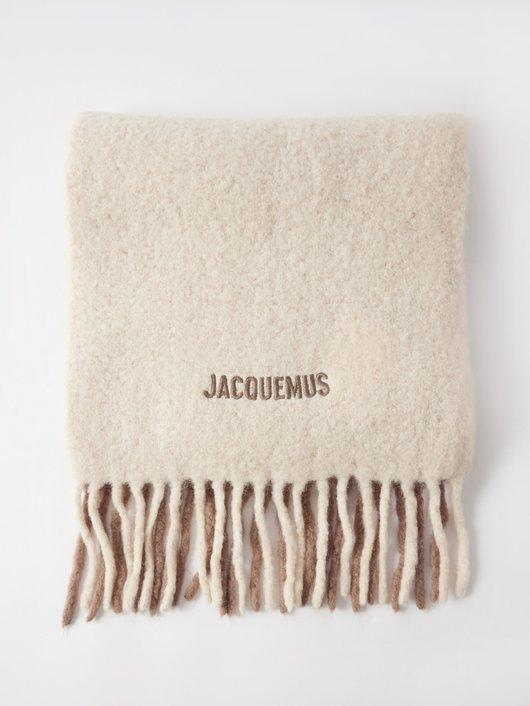

In [63]:
from io import BytesIO
ds_pandas[ds_pandas["category3_code"]=="SCARVES"].iloc[0]["image"]["bytes"]
PIL.Image.open(BytesIO(ds_pandas[ds_pandas["category3_code"]=="SCARVES"].iloc[0]["image"]["bytes"]))

In [28]:
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='products'), CollectionDescription(name='images2'), CollectionDescription(name='face_embeddings2'), CollectionDescription(name='music_collection3'), CollectionDescription(name='images'), CollectionDescription(name='images3'), CollectionDescription(name='face_embeddings'), CollectionDescription(name='products2')])

In [31]:
image = PIL.Image.open("../assets/examples/jewelry.png")
#image = dset[0]["image"]

inputs = processor(images=image, return_tensors="pt")
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)
    embedding = outputs.pooler_output

In [40]:
inputs = processor(images=dset[0]["image"], return_tensors="pt")
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)
    embedding = outputs.pooler_output
embedding.mean()

tensor(-0.0030)

In [34]:
results = client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold = 0.6,
    limit=10,
    with_vectors=True
)

In [35]:
res = [result.id for result in results]
res

[0, 65, 2, 83, 86, 84, 35, 18, 1, 61]

In [37]:
results[:2]

[ScoredPoint(id=0, version=0, score=0.9999728, payload={'category2_code': 'ACCESSORIES', 'category3_code': 'FASHION JEWELRY', 'id': 0, 'title': 'Lotus 24kt gold-plated clip earrings'}, vector=[0.023444163, 0.032680605, -0.025713, -0.004129216, -0.034596123, 0.03294613, -0.036808446, 0.02642433, 0.040949762, 0.0034274443, 0.03229824, 0.06173034, 0.02060785, 0.050166424, 0.011171786, 0.04350872, -0.029726425, 0.0040361355, 0.029167222, 0.016301189, -0.0033646477, -0.05042323, 0.009701093, -0.01679941, 0.027495649, -0.04837705, 0.0083487965, 0.0314623, -0.024907382, 0.0052075125, -0.014879833, 0.055302307, -0.022235738, 0.007008168, -0.02627106, 0.0492965, 0.012637484, 0.017521514, -0.06570778, -0.058591638, -0.018025456, -0.025045967, -0.021652905, 0.021259356, -0.025490655, -0.008916805, 0.05480335, -0.07496366, 0.034494903, 0.029049776, 0.053904578, 0.02564899, -0.028108193, -0.006617919, 0.0038749734, 0.0052059754, -0.02760647, 0.00038809984, 0.004794068, -0.035103112, -0.034553792, 0

In [38]:
client.get_collection("products")

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=3000, indexed_vectors_count=0, points_count=3000, segments_count=8, config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=768, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None), payload_schema=

In [39]:
from io import BytesIO
images = []
for row in ds_pandas.iloc[res,]["image"]:
    images.append(np.array(PIL.Image.open(BytesIO(row["bytes"]))))

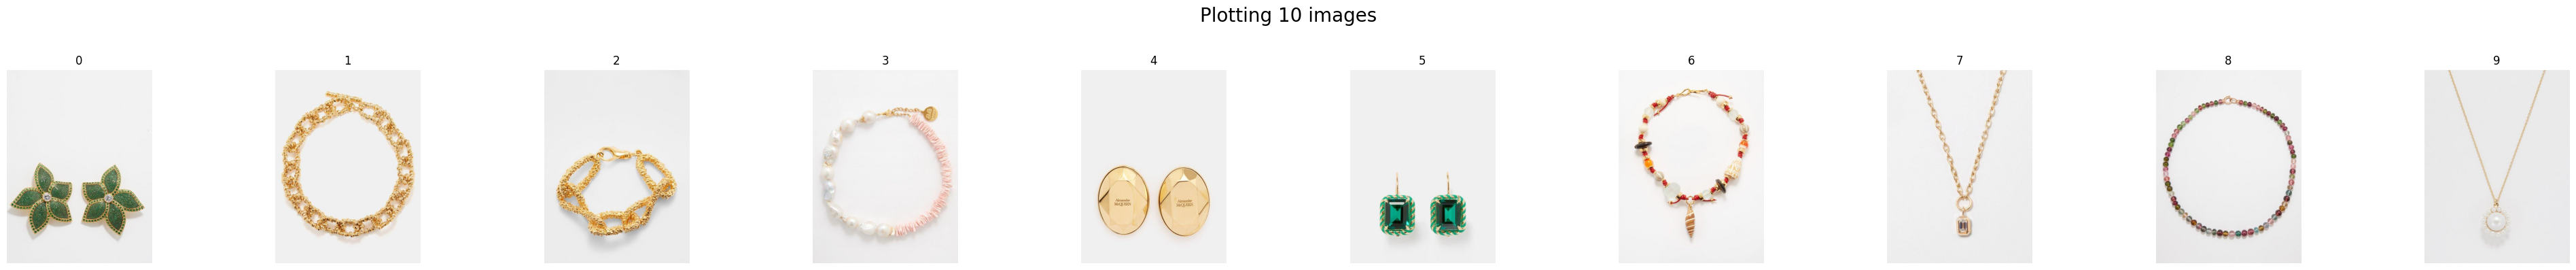

In [40]:
plot_images_horizontal(images, titles=[str(i) for i in range(len(images))])

In [38]:
ds_pandas

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,...,imageurl,full_price,price,full_price_eur,price_eur,flg_discount,image,pixel_values,pooler_output,id
0,Matches Fashion,2023-11-17,FRA,EUR,BEGÜM KHAN,WOMENS,ACCESSORIES,FASHION JEWELRY,1548400,Lotus 24kt gold-plated clip earrings,...,https://assetsprx.matchesfashion.com/img/15484...,1504.0,1504.0,1504.0,1504.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.8666667, 0.8745098, 0.88235295, 0.8823529...","[-0.07132233, 0.046879668, -0.13566877, -0.113...",0
1,Matches Fashion,2023-11-17,FRA,EUR,IRENE NEUWIRTH,WOMENS,ACCESSORIES,FINE JEWELRY,1551010,Gemmy Gem tourmaline & 18kt rose-gold necklace,...,https://assetsprx.matchesfashion.com/img/15510...,10275.0,10275.0,10275.0,10275.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.8666667, 0.8666667, 0.8666667, 0.8666667,...","[0.030957637, -0.13023941, -0.17789945, -0.094...",1
2,Matches Fashion,2023-11-17,FRA,EUR,ALIGHIERI,WOMENS,ACCESSORIES,FASHION JEWELRY,1551867,The Rocky Road 24kt gold-plated bracelet,...,https://assetsprx.matchesfashion.com/img/15518...,513.0,513.0,513.0,513.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.8509804, 0.8509804, 0.8509804, 0.84313726...","[0.025865052, 0.041903485, -0.14762315, -0.266...",2
3,Matches Fashion,2023-11-17,FRA,EUR,HERNO,MENS,CLOTHING,COATS,1533662,Hooded nylon-blend parka,...,https://assetsprx.matchesfashion.com/img/15336...,641.0,641.0,641.0,641.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.9372549, 0.9372549, 0.9372549, 0.9372549,...","[0.12628184, -0.11758295, -0.19774295, 0.28130...",3
4,Matches Fashion,2023-11-17,FRA,EUR,LES OTTOMANS,WOMENS,HOMEWARE,TABLETOP,1503435,Set of four hand-painted ceramic dinner plates,...,https://assetsprx.matchesfashion.com/img/15034...,269.0,269.0,269.0,269.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.90588236, 0.90588236, 0.90588236, 0.90588...","[0.043028787, -0.24418047, -0.12301574, 0.2549...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Matches Fashion,2023-11-17,FRA,EUR,BOTTEGA VENETA,WOMENS,ACCESSORIES,WALLETS,1427062,Intrecciato-leather wallet,...,https://assetsprx.matchesfashion.com/img/14270...,550.0,550.0,550.0,550.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.92941177, 0.92941177, 0.92941177, 0.92941...","[-0.21392262, 0.13088344, 0.0685483, 0.0286724...",95
96,Matches Fashion,2023-11-17,FRA,EUR,MONCLER,MENS,CLOTHING,POLO SHIRTS,1485407,Logo-embroidered cotton-piqué polo shirt,...,https://assetsprx.matchesfashion.com/img/14854...,250.0,250.0,250.0,250.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.9529412, 0.9529412, 0.9529412, 0.9529412,...","[-0.47692126, 0.26056388, -0.09165532, 0.31468...",96
97,Matches Fashion,2023-11-17,FRA,EUR,CHRISTIAN LOUBOUTIN,MENS,BAGS,TRAVEL BAGS,1531726,Sneakender logo-canvas jacquard holdall,...,https://assetsprx.matchesfashion.com/img/15317...,1811.0,1811.0,1811.0,1811.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.88235295, 0.88235295, 0.88235295, 0.88235...","[0.17159674, -0.31225964, -0.2473743, -0.13404...",97
98,Matches Fashion,2023-11-17,FRA,EUR,CASTAÑER,MENS,SHOES,ESPADRILLES,1464505,Pablo canvas and jute espadrilles,...,https://assetsprx.matchesfashion.com/img/14645...,99.0,99.0,99.0,99.0,0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"[[[0.94509804, 0.94509804, 0.94509804, 0.94509...","[0.10460234, 0.1998064, -0.022795446, 0.079415...",98
